In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import scipy.io as scio
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

### Data preprocssing: prepare data for training & test sets

In [2]:
data=scio.loadmat("trainA.mat")
input_d=data['input']
output_d=data['output']
predict_in=data['predict_in']
predict_out=data['predict_out']



In [3]:
#train=[0:7200]
#test=[7200:8832]


numsize=0.7
numsample=len(input_d)

num_train=round(numsize*numsample)

X_train_df = input_d[0:7200,3:4]
y_train_df = output_d[0:7200,3:4]

X_test_df = input_d[7200:8784,3:4]
y_test_df = output_d[7200:8784,3:4]

In [4]:
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
y_train = y_train_df
X_test = X_test_df
y_test = y_test_df 

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7200, 1) (7200, 1)
(1584, 1) (1584, 1)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **48**

In [5]:
X_length=7200
y_length=1584
start=0
#end=X_length


#start = np.cumsum(X_length) - X_length
#end   = np.cumsum(X_length)

slider = 48
slider1= 48
X_train_all = []
y_train_all = []

#for i in range(7200):
    
    #X_subset = X_train[start[i]:end[i],:]
    #y_subset = y_train[start[i]:end[i],:]
    
X_subset = np.array([X_train[i:i+slider] for i in range(0, X_length,48)])
y_subset = np.array([y_train[i:i+slider] for i in range(0, X_length,48)])
    
X_train_all.append(X_subset)
y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0],48)])
print(X_train.shape,y_train.shape,X_test.shape)

(150, 48, 1) (150, 48, 1) (33, 48, 1)


### Define the LSTM structure

In [6]:
t=time.perf_counter()
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [7]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
Total params: 57,200
Trainable params: 57,200
Non-trainable params: 0
_________________________________________________________________


2022-12-23 10:48:05.068903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
lstm_model

### Train & save the LSTM model

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
2/2 [==============================] - 1s 197ms/step - loss: 0.0951 - val_loss: 0.1686
Epoch 2/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0915 - val_loss: 0.1613
Epoch 3/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0875 - val_loss: 0.1529
Epoch 4/50
2/2 [==============================] - 0s 51ms/step - loss: 0.0828 - val_loss: 0.1424
Epoch 5/50
2/2 [==============================] - 0s 55ms/step - loss: 0.0770 - val_loss: 0.1287
Epoch 6/50
2/2 [==============================] - 0s 47ms/step - loss: 0.0694 - val_loss: 0.1109
Epoch 7/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0597 - val_loss: 0.0906
Epoch 8/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0485 - val_loss: 0.0875
Epoch 9/50
2/2 [==============================] - 0s 51ms/step - loss: 0.0477 - val_loss: 0.0863
Epoch 10/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0363 - val_loss: 0.0635
Epoch 11/50
2/2 [===========

Text(0.5, 1.0, 'LSTM')

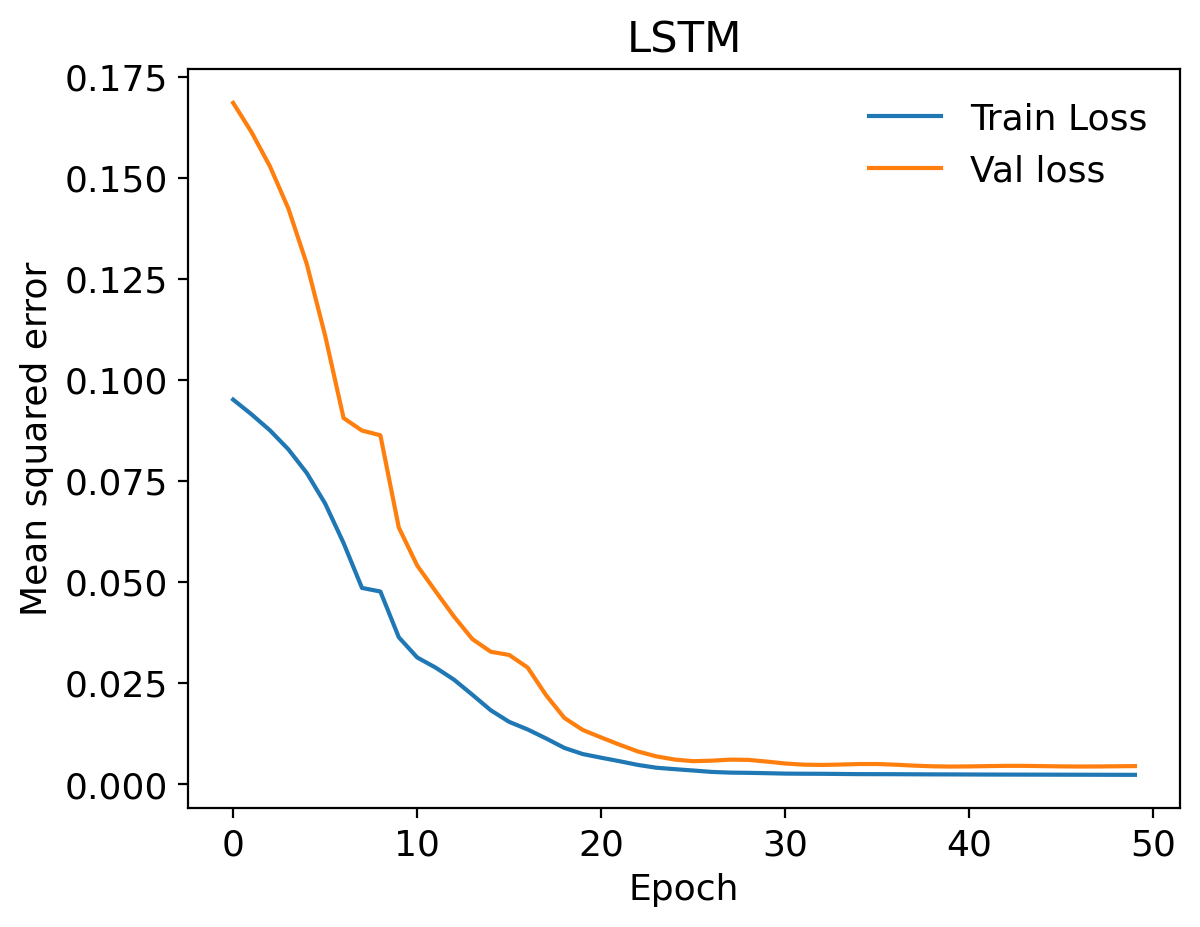

In [10]:
plot_history(history)
plt.title('LSTM')

In [11]:
model_path = os.path.join('saved_model')
make_dir(model_path)

In [12]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
lstm_model.save(os.path.join(model_path,'LSTM_model.h5'))

### Evaluate the trained model

In [13]:
# reload the saved model
lstm_model = load_model(os.path.join(model_path,'LSTM_model.h5'))

In [14]:
y_test_pre = lstm_model.predict(X_test)

print(y_test_pre.shape)
y_test_pre = y_test_pre.reshape(1584,1)
print(f'coast:{time.perf_counter() - t:.8f}s' )

2/2 [==============================] - 0s 6ms/step
(33, 48)
coast:5.65390696s


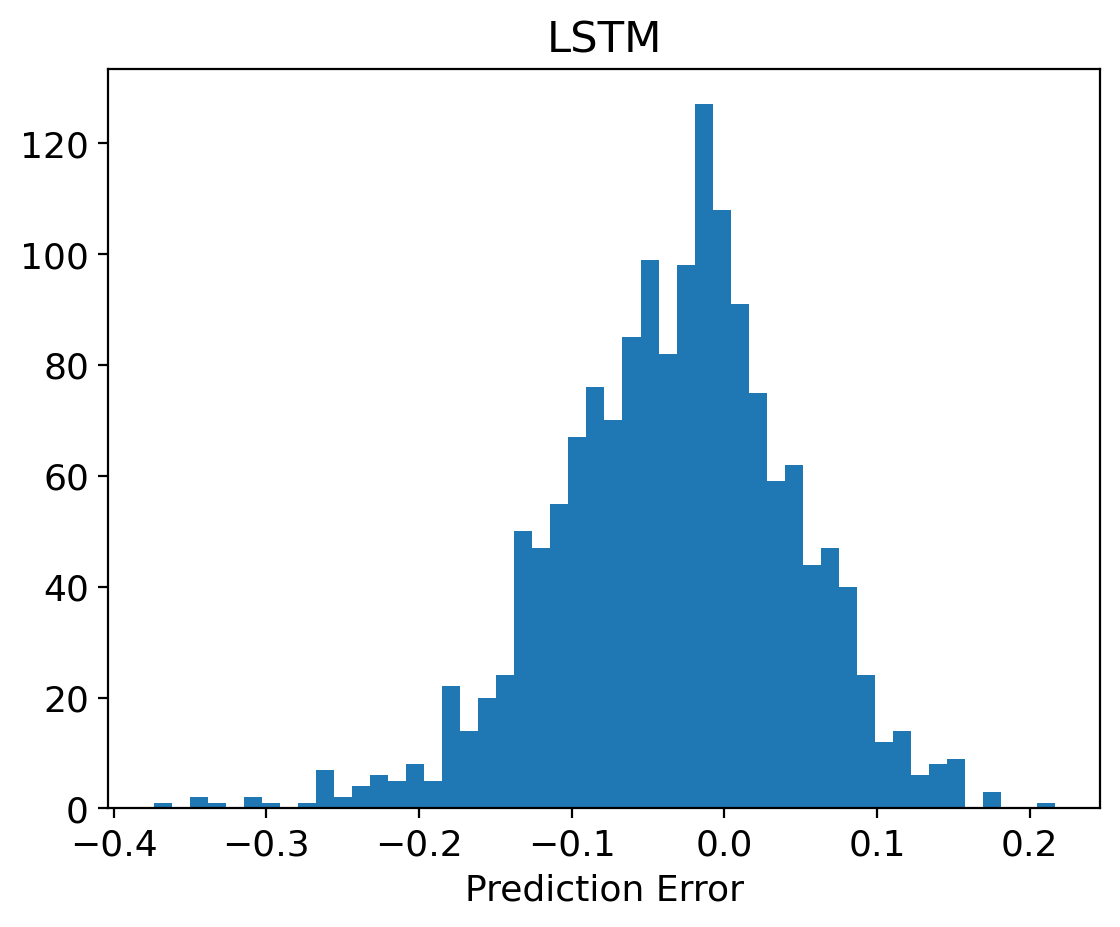

In [15]:
# histogram
error = y_test_pre - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('LSTM')
plt.show()

0.6516247149220684

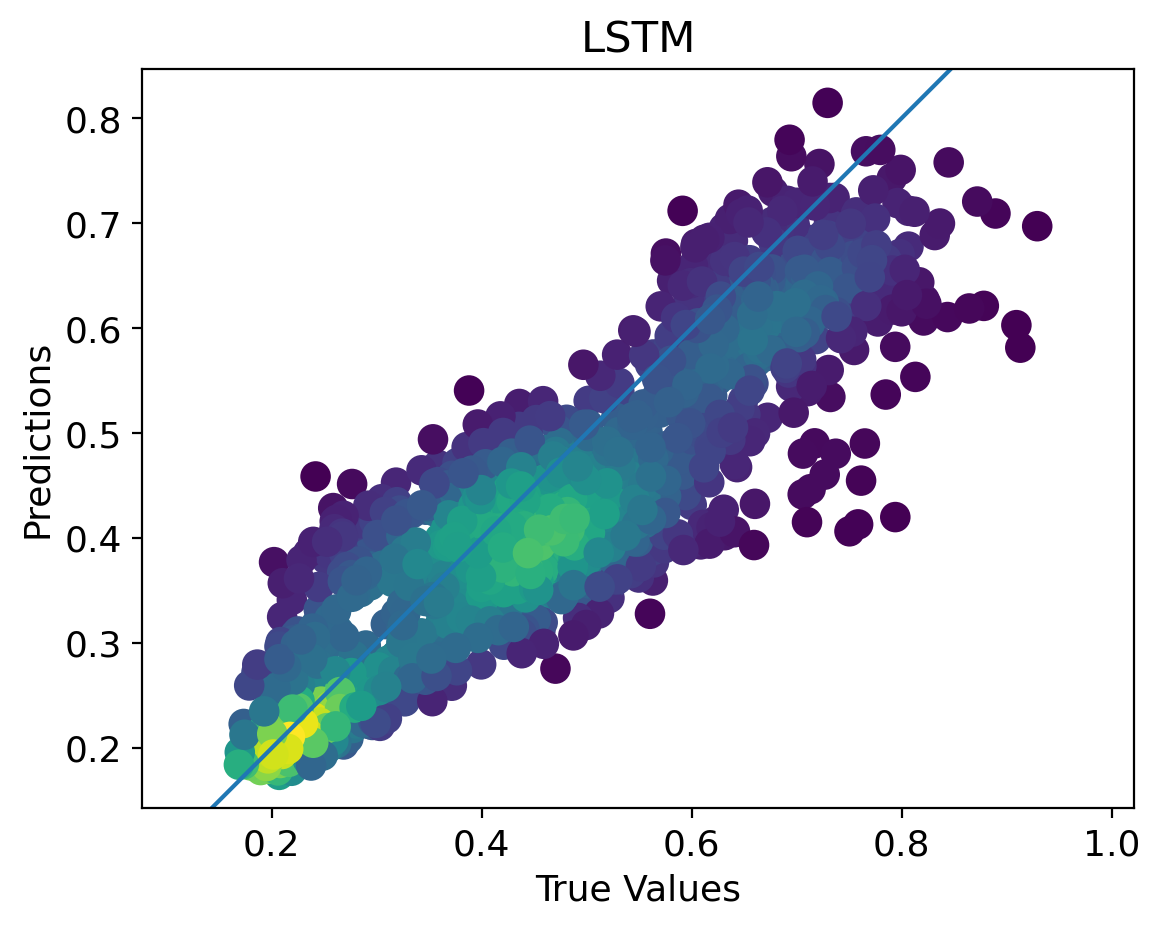

In [16]:

# relationship between true and predicted value
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde

xy = np.vstack([np.transpose(y_test),np.transpose(y_test_pre)])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pre, c=z, s=100)
#plt.show()

#plt.scatter(y_test, y_test_pre)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('LSTM')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
from sklearn.metrics import r2_score
r2_score(y_test_pre,y_test)

Text(0.5, 1.0, 'LSTM')

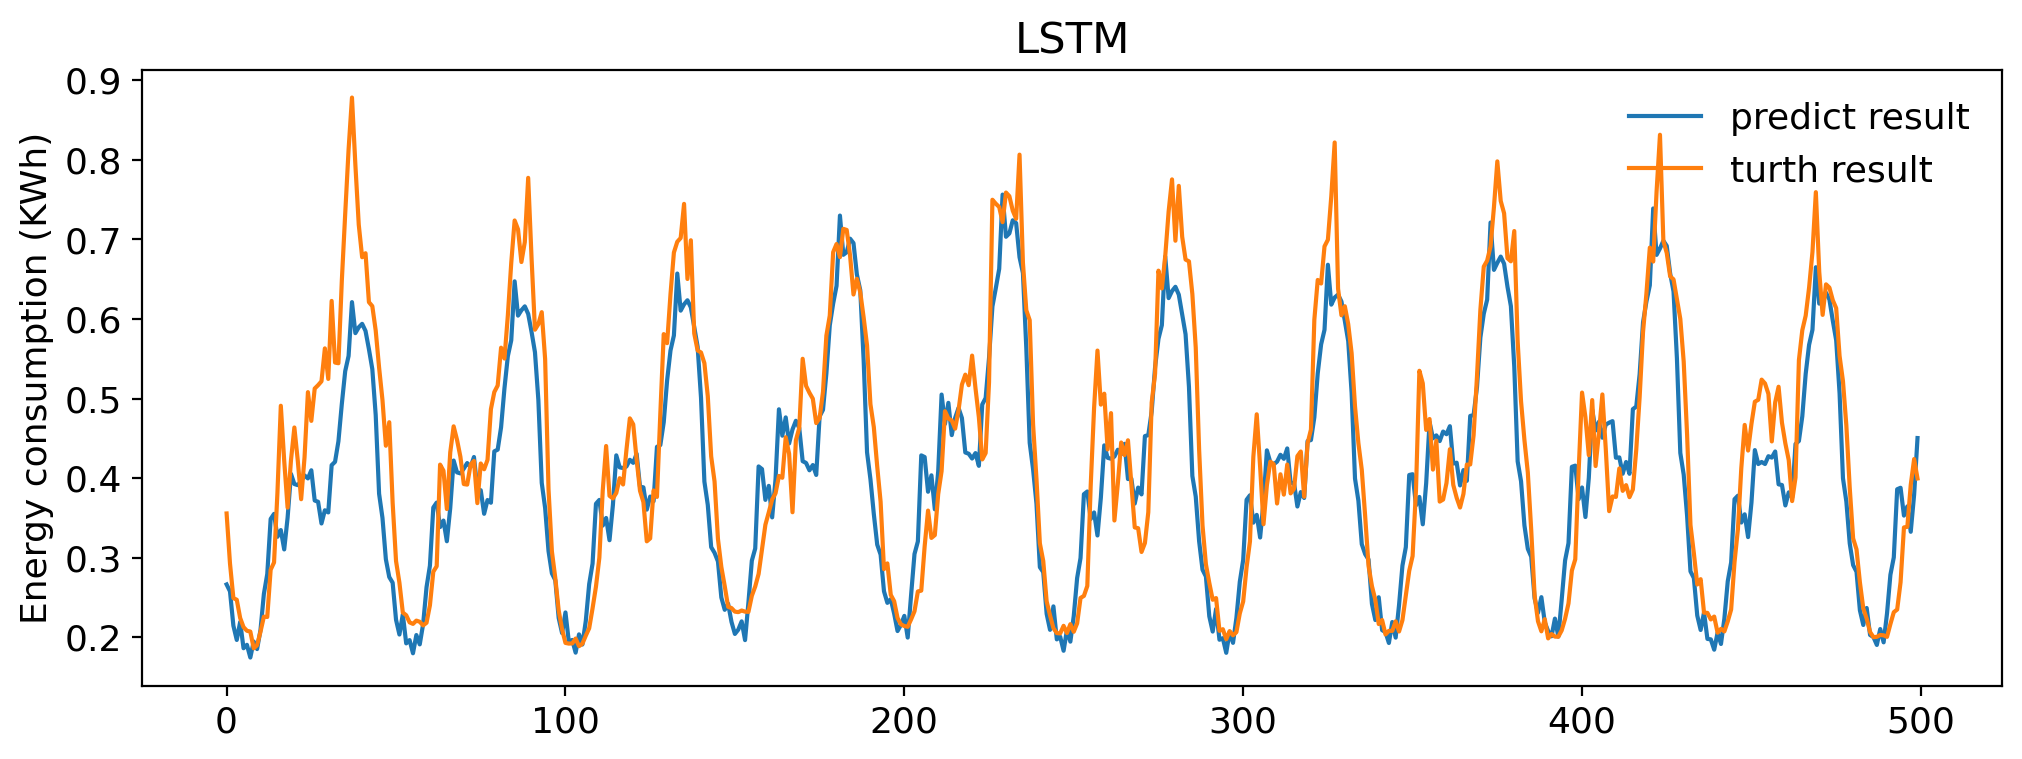

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))
x = range(500)
label1='predict result'
label2='turth result'
axes.plot(x, y_test_pre[0:500], label=label1)
axes.set_ylabel("Energy consumption (KWh)")
axes.plot(x, y_test[0:500], label=label2)
axes.legend()
plt.title('LSTM')

In [18]:
RMSE=np.sqrt(np.mean((y_test_pre-y_test)**2))
MAPE=np.mean(abs(y_test-y_test_pre)/y_test)*100
print(RMSE,MAPE)

0.08426096604384202 14.865592785722212


## Calculate SHAP value

In [19]:
import shap
shap.initjs()
explain_data = np.reshape(X_train,(7200,1))
explainer = shap.Explainer(lstm_model, explain_data)
print(explainer)
#explain_data = X_train[np.random.choice(X_train.shape[0], 10, replace=False)]

shap_values = explainer(explain_data)

print(shap_values)


/opt/anaconda3/envs/Opt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Exact explainer: 7201it [01:08, 92.26it/s]                                      


.values =
array([[[ 0.00037715, -0.00065788,  0.00108866, ...,  0.00171077,
          0.00013845,  0.00032155]],

       [[ 0.00084836, -0.00020601,  0.00236011, ...,  0.00349785,
          0.00140816,  0.00114038]],

       [[ 0.00089562, -0.00015909,  0.00249157, ...,  0.00368142,
          0.00153896,  0.00122516]],

       ...,

       [[-0.00035646,  0.00156467, -0.00123127, ..., -0.00193736,
          0.00032584, -0.00020926]],

       [[-0.00061448,  0.00065517, -0.00165065, ..., -0.00246003,
         -0.00065315, -0.00074176]],

       [[-0.00102985, -0.00115647, -0.00243912, ..., -0.00349229,
         -0.00253802, -0.00158951]]])

.base_values =
array([[0.06738245, 0.04061955, 0.04668257, ..., 0.0835845 , 0.06482631,
        0.06804298],
       [0.06738245, 0.04061955, 0.04668257, ..., 0.0835845 , 0.06482631,
        0.06804298],
       [0.06738245, 0.04061955, 0.04668257, ..., 0.0835845 , 0.06482631,
        0.06804298],
       ...,
       [0.06738245, 0.04061955, 0.04668257,

In [20]:
shap_values.base_values=np.reshape(shap_values.base_values, (345600,1))
shap.force_plot( shap_values.base_values[2000], explain_data[2000])